In [1]:
import gym

In [2]:
env = gym.make('Pong-ram-v0')

[2017-10-22 23:40:59,240] Making new env: Pong-ram-v0


In [3]:
import numpy as np
import ipywidgets as W
from PIL import Image

In [4]:
env.action_space

Discrete(6)

In [5]:
env.reward_range

(-inf, inf)

In [6]:
env.reset()

array([192,   0,   0,   0, 110,  38,   0,   7,  63,   1,  60,  59,   0,
         0,   0,  62, 255,   0, 255, 253,   0,   8,   0,  24, 128,  32,
         1,  86, 247,  86, 247,  86, 247, 134, 243, 245, 243, 240, 240,
       242, 242,  32,  32,  64,  64,  64, 188,  65, 189,   0,   8, 109,
        37,  37,  60,   0,   0,   0,   0, 109, 109,  37,  37, 192, 192,
       192, 192,   1, 192, 202, 247, 202, 247, 202, 247, 202, 247,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  54, 236, 242, 121, 240], dtype=uint8)

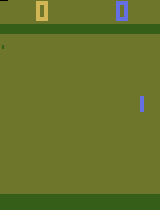

In [7]:
Image.fromarray(env.render(mode='rgb_array'))

In [8]:
from io import BytesIO
def to_png(a):
    with BytesIO() as bio:
        Image.fromarray(a).save(bio, 'png')
        return bio.getvalue()

觀察

In [9]:
from functools import partial
last_ob = None
def pressed(a, x):
    global last_ob
    observation, reward, done, info = env.step(a)
    img = env.render(mode='rgb_array')
    screen.value = to_png(img)
    txt.value = "{} {} {} {:02x} {:02x} {:02x}".format(reward, done, info, 
                                                       observation[49],observation[54], observation[60] )
    h = "<table>"
    for i in range(8):
        h+="<tr>"
        for j in range(16):
            color = 'black'
            if last_ob is not None:
                if last_ob[16*i+j]!=observation[16*i+j]:
                    color='red'
            h+="<td style='width: 2.5em;color: %s'>%02X</td>"%(color, observation[16*i+j])
        h+="</tr>"
    h+="</table"
    html.value=h
    last_ob = observation.copy()
buttons = [W.Button(description=str(i)) for i in range(6)]
for i in range(6):
    buttons[i].on_click(partial(pressed,i))
txt = W.Text()
screen = W.Image()
html = W.HTML()
display(W.HBox([screen, W.VBox(buttons), W.VBox([txt, html])]))
env.reset();


HBox(children=(Image(value=b''), VBox(children=(Button(description='0', style=ButtonStyle()), Button(description='1', style=ButtonStyle()), Button(description='2', style=ButtonStyle()), Button(description='3', style=ButtonStyle()), Button(description='4', style=ButtonStyle()), Button(description='5', style=ButtonStyle()))), VBox(children=(Text(value=''), HTML(value='')))))

In [10]:
from PIL import ImageDraw

In [11]:
from time import sleep
screen = W.Image()
display(screen)
observation = env.reset()
wait = 0
for i in range(50):
    env.step(0)
for i in range(2000):
    x,y0 = observation[[49,54]]
    y2 = observation[60]
    dy = (observation[56]+127)%256-127
    dx = (observation[58]+127)%256-127
    if dx < 0:
        y = (int(y0 - (186-x)*dy/dx)-44)%(326)
        if y>163:
            y=326-y
        y+=38
    else:
        y=115
    if y2<y-3:
        if 40<y-y2 or wait<=0:
            a = 3
            wait=(40-(y-y2))//8
        else:
            wait-=1
            a=0
    elif y2 > y+3:
        if y2-y>40 or wait<=0:
            a = 2
            wait=(40-(y2-y))//8
        else:
            wait-=1
            a = 0
    else:
        a = 0
        wait =0
    observation, reward, done, info = env.step(a)
    img = env.render(mode='rgb_array')
    screen.value = to_png(img)
    sleep(1/60)

Image(value=b'')

In [194]:
from time import sleep
from random import randint, random, shuffle, choice

α = 3e-2
γ = 0.9
ϵ = .1

Q=np.zeros((100,3))
actions = [0,2,3]
def compute_s(observation):
    dx = (observation[58]+127)%256-127
    if dx>=0:
        return 0
    dy = (observation[56]+127)%256-127
    x,y0 = observation[[49,54]]
    y2 = observation[60]    
    y = (int(y0 - (186-x)*dy/dx)-44)%(326)
    if y>163:
        y=326-y
    y+=38
    s = (y-y2)//2
    if s<-49:
        s=-49
    elif s>49:
        s=49
    return s+50

def Qlearn(test=False, screen=None, T=40):
    observation = env.reset()
    for i in range(50):
        observation, reward, done, info =env.step(0)
    s2 = compute_s(observation)
    total_r = 0
    for i in range(T):
        s = s2
        if not test and random()< ϵ:
            a = choice(actions)
        else:
            a = actions[np.argmax(Q[s])]
        observation, reward, done, info = env.step(a)        
        s2 = compute_s(observation)
        r = reward
        total_r+=r
        if not test and s!=0:
            if s2==0:
                r=1
            a = max(0, a-1)
            Q[s][a] += α*(r+γ*Q[s2].max() - Q[s][a])
            #if r!=0:
                #return total_r
        if screen is not None:
            img = env.render(mode='rgb_array')
            screen.value = to_png(img)
            sleep(1/60)
    return total_r

In [195]:
%matplotlib inline
from matplotlib import pyplot as plt

Image(value=b'')

Text(value='')

0 -0.96 0.1
200 -0.02 0.1
400 -0.02 0.1
600 -0.06 0.1
800 -0.04 0.1


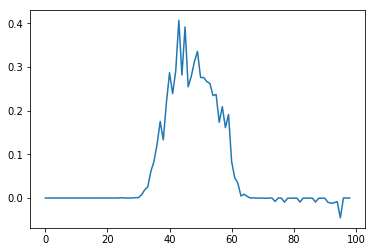

In [176]:
screen = W.Image()
display(screen)
txt =W.Text()
display(txt)
Q=np.zeros((100,3))
ϵ = .1
α = 1e-2
γ = 1
for j in range(1001):
    if j%20==0:
        txt.value="j={} r={} {} ".format(j, r/20,  ϵ)
        plt.clf()
        plt.plot(Q[1:].max(axis=1))
        with BytesIO() as bio:
            plt.savefig(bio)            
            screen.value = bio.getvalue()
        if j%200==0:
            r=0
            for i in range(100):
                r+=Qlearn(test=True)
            print(j, r/100, ϵ)
        r=0

    r+=Qlearn()


In [192]:
screen = W.Image()
display(screen)
Qlearn(test=True, screen=screen, T=40)

Image(value=b'')

-1.0

Image(value=b'')

Text(value='')

0 -2.45 0.1
200 -1.0 0.1
400 0.05 0.1
600 -0.75 0.1
800 -1.8 0.1
1000 -1.4 0.1


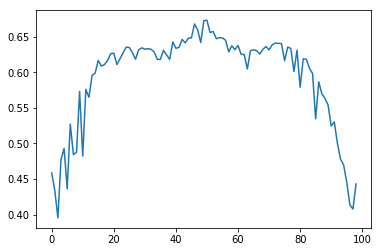

In [207]:
screen = W.Image()
display(screen)
txt =W.Text()
display(txt)
#Q=np.zeros((100,3))
ϵ = .1
α = 1e-2
γ = 1
for j in range(1001):
    if j%10==0:
        txt.value="j={} r={} {} ".format(j, r/10,  ϵ)
        plt.clf()
        plt.plot(Q[1:].max(axis=1))
        with BytesIO() as bio:
            plt.savefig(bio)            
            screen.value = bio.getvalue()
        if j%200==0:
            r=0
            for i in range(20):
                r+=Qlearn(test=True, T=1000)
            print(j, r/20, ϵ)
        r=0

    r+=Qlearn(T=1000)


In [203]:
screen = W.Image()
display(screen)
Qlearn(test=True, screen=screen, T=1000)

Image(value=b'')

1.0

In [206]:
Q.argmax(axis=1)[50:]

array([0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

In [15]:
from time import sleep
from random import randint, random, shuffle, choice

α = 3e-2
γ = 0.9
ϵ = .3

# x y0 y2 dy, a
Q=np.zeros((210, 210, 210, 20, 3))
actions = [0,2,3]
def compute_s(observation):
    dx = (observation[58]+127)%256-127
    if dx>0:
        return None
    dy = (observation[56]+127)%256-127
    x,y0 = observation[[49,54]]
    y2 = observation[60]
    assert 0<=x<210
    assert -9<=dy<=9
    return (x,y0,y2,dy+9)

def Qlearn2(test=False, screen=None, T=300):
    observation = env.reset()
    for i in range(50):
        observation, reward, done, info =env.step(0)
    s2 = compute_s(observation)
    total_r = 0
    for i in range(T):
        s = s2
        if not test and random()< ϵ:
            a = choice(actions)
        elif s is None:
            a = 0
        else:
            try:
                a = actions[np.argmax(Q[s])]
            except:
                print(s)
        observation, reward, done, info = env.step(a)        
        s2 = compute_s(observation)
        r = reward
        total_r+=r
        if not test and s is not None:
            if s2 is None:
                r=1
            a = max(0, a-1)
            Q[s][a] += α*(r+γ*Q[s2].max() - Q[s][a])
        if screen is not None:
            img = env.render(mode='rgb_array')
            screen.value = to_png(img)
            sleep(1/60)
    return total_r

In [ ]:
#screen = W.Image()
#display(screen)
txt =W.Text()
display(txt)
for j in range(20001):
    if j%20==0:
        txt.value=str(j)
        r=0
        if j%200==0:
            for i in range(100):
                r+=Qlearn2(test=True)
            print(j, r/100)
    Qlearn2()


Text(value='')

0 -6.0
200 -5.99
400 -5.96


In [20]:
r/100

-4.31